## Improvement of Raw Transformation

### Setup of the Data

#### Initialization

In [27]:
import MDAnalysis as md
import matplotlib.pyplot as plt
import numpy as np
import time # For benchmarking

# Load data
t_set = 100

if t_set == 25:
    # 25 ns data
    file_dir = "/Users/alejandro/Desktop/mddocs/processing-analysis/fullcol-0308/results-0808"
elif t_set == 100:
    # 100 ns data
    file_dir = "/Users/alejandro/Desktop/mddocs/processing-analysis/fullcol-100ns-2008"

u = md.Universe(file_dir + "/md_1.tpr", file_dir + "/md_1_noPBC.xtc")
u.trajectory[-1]
protein = u.select_atoms("protein")
xd, yd, zd = u.trajectory[-1].dimensions[0:3]/10

t_eq = 20000 # ps
# Time Data
ti = u.trajectory[0].time
tf = u.trajectory[-1].time
nt = len(u.trajectory)-1
deltat = (tf-ti)/nt
t = np.linspace(ti,tf,nt+1)
maskt = (t >= t_eq)

#### Functions

In [28]:
def get_mean_coords_mol(molecule, mask, group):
    # Get the Mean Coordinates of the molecule
    mean_coords = None
    chains = protein.fragments[3*molecule:3*molecule + 3]
    colmol = chains[0] + chains[1] + chains[2]
    colmol = colmol.select_atoms(group)
    for ts in u.trajectory[mask]:
        coords = colmol.positions / 10
        if mean_coords is None:
            mean_coords = coords.astype(float)
            n = 1
        else:
            n += 1
            mean_coords += (coords - mean_coords) / n

    # Ordering the z for unwrapping
    order = np.argsort(mean_coords[:, 2])
    return mean_coords[order]

def mean_com(mask, group = "backbone"):
    fib_mean = None
    fib = protein.select_atoms(group)
    for ts in u.trajectory[mask]:
        com = fib.center_of_mass() / 10
        if fib_mean is None:
            fib_mean = com
            n = 1
        else:
            n += 1
            fib_mean += (com - fib_mean) / n
    
    return com[0], com[1], com[2]

def clean_phi(y, x):
    # Get the phi effectively getting rid of the jumps
    phi_p = np.atan2(y, x)
    phi_uw = np.unwrap(phi_p)
    return phi_uw

def cyl_proj(molecule, y_fun, x_fun, r_min = False):
    z = molecule[:, 2]
    x = molecule[:, 0] - x_fun(z)
    y = molecule[:, 1] - y_fun(z)

    if r_min == False:
        r = np.sqrt(y**2 + x**2)
        phi = clean_phi(y, x)
    else: # Filter near 0 r
        r = np.sqrt(y**2 + x**2)
        mask_rmin = (r > r_min)
        r = r[mask_rmin]
        x_filt = x[mask_rmin] 
        y_filt = y[mask_rmin] 
        phi = clean_phi(y_filt, x_filt)
        z = z[mask_rmin]

    return r, phi, z

def linfitandr2(x, y):
    fit_res = np.polyfit(x, y, 1, full=True) 
    m, b = fit_res[0]
    # R2
    SSE = fit_res[1][0] 
    SST = np.sum((y - np.mean(y)) ** 2) 
    R2 = 1 - SSE/SST
    return m, b, R2

### Center of the Fibril - Line Approximation

In [29]:
x_cfp, y_cfp, _ = mean_com(maskt) # Center of Mass

# Line through z-axis
x_cf = lambda z: x_cfp
y_cf = lambda z: y_cfp

### One Molecule

View $x,y,z$ visualization of centered molecule. Fix the unwrapping.

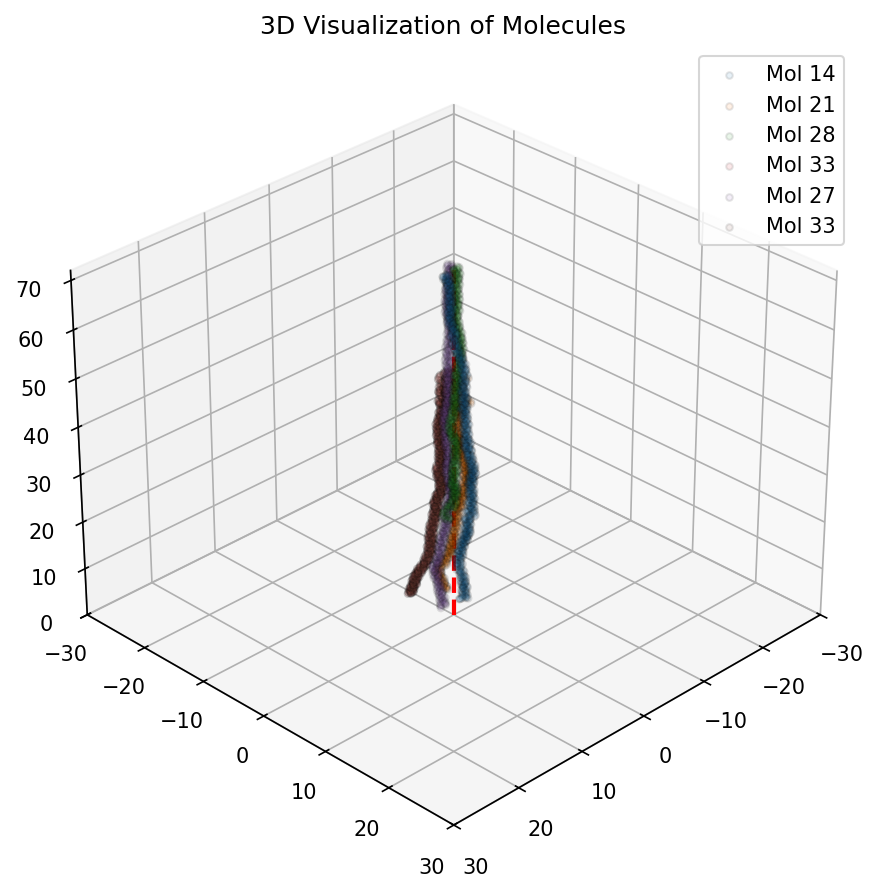

In [30]:
mols = [14, 21, 28, 33, 27, 33]

fig = plt.figure(figsize=(6,6), dpi=150)
ax = fig.add_subplot(111, projection='3d')

cmap = plt.get_cmap("tab10")   # Coloring
colors = [cmap(j) for j in range(len(mols))]
for i, mol in enumerate(mols):
    molecule_mean = get_mean_coords_mol(mol, maskt, "name CA")

    x = molecule_mean[:, 0] - x_cfp
    y = molecule_mean[:, 1] - y_cfp
    z = molecule_mean[:, 2]

    ax.scatter(x, y, z, s=10, color=colors[i], edgecolor='k', alpha=0.1, label=f'Mol {mol}')


ax.set_xlim3d([-30, 30])
ax.set_ylim3d([-30, 30])
ax.set_zlim3d([0, 72])

# Centerline of fibril
z_line = np.linspace(0, 72, 100)
ax.plot(np.zeros_like(z_line), np.zeros_like(z_line), z_line, color='r', linestyle='dashed', linewidth=2)

# Angle
ax.view_init(elev=30, azim=45)

plt.title("3D Visualization of Molecules")
plt.tight_layout()
plt.legend()
plt.show()

In [31]:
mol = 33
r_min = 1 #nm
molecule_mean = get_mean_coords_mol(mol, maskt, "name CA")
rad_mol, phi_mol, z_mol = cyl_proj(molecule_mean, y_cf, x_cf)

# Bin Catalogation - Radius
bins = 5
cat_bins = np.linspace(rad_mol.min(), rad_mol.max(), bins+1)
bin_ids = np.digitize(rad_mol, cat_bins) - 1
bin_rad = 0.5 * (cat_bins[:-1] + cat_bins[1:])

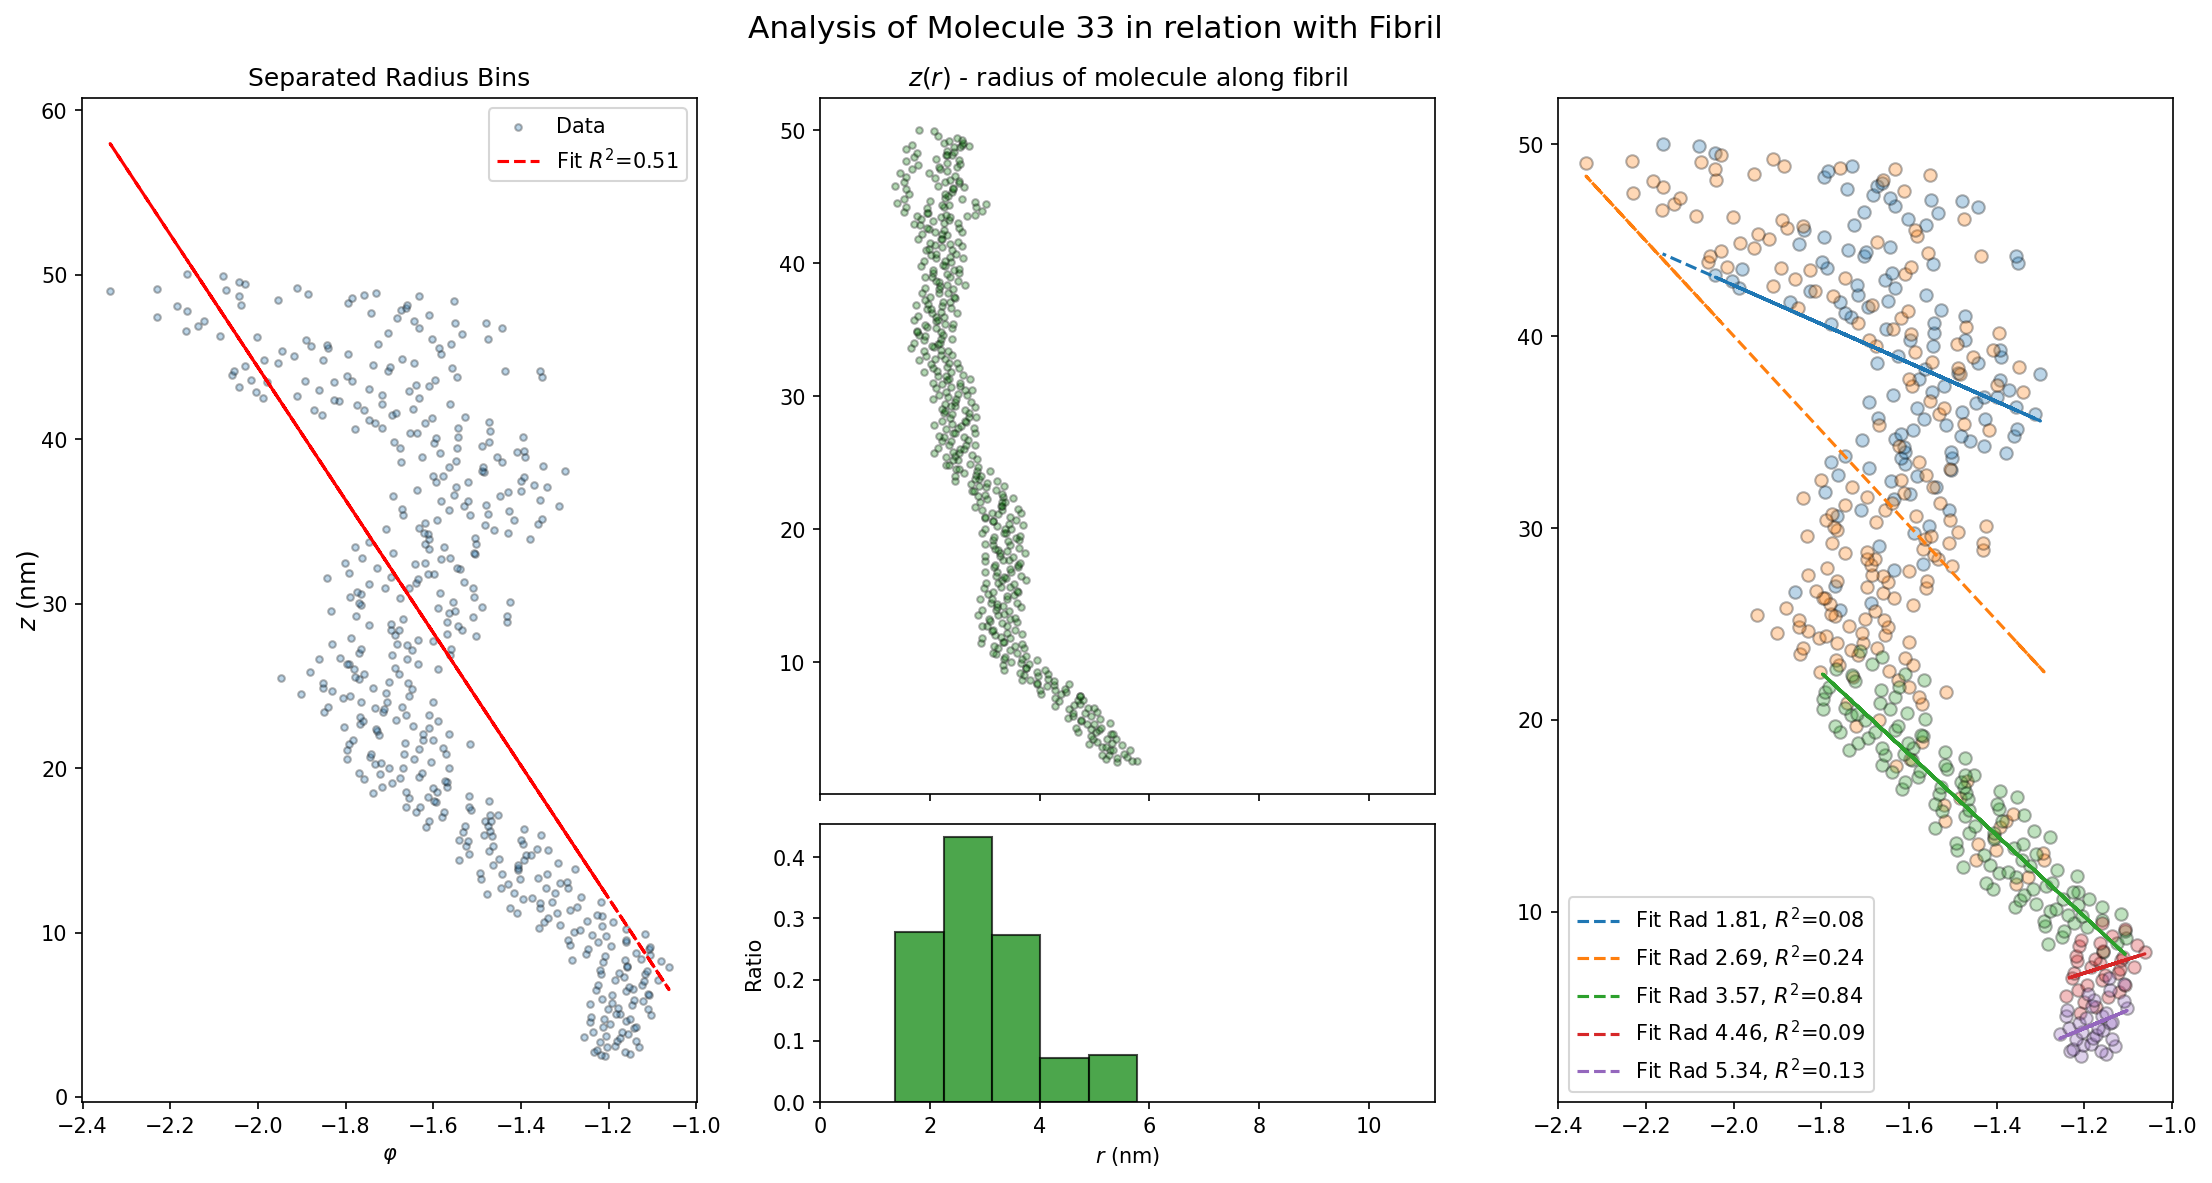

In [32]:
# --- Build figure with GridSpec: left & middle span both rows; right column is split ---
fig = plt.figure(figsize=(15, 8), dpi=150)

gs = fig.add_gridspec(2, 3, height_ratios=[1, 0.4])

ax0 = fig.add_subplot(gs[:, 0])   # left: per-chain phi(z)
ax1 = fig.add_subplot(gs[0, 1])   # middle: combined phi(z) + fit
ax2 = fig.add_subplot(gs[1, 1], sharex=ax1)   # top-right: z vs r
ax3 = fig.add_subplot(gs[:, 2])  # bottom-right: histogram of r

# --- Left: Angle Projection of Molecule & Fit ---
ax0.scatter(phi_mol, z_mol, s=10, edgecolor='k', alpha=0.3, label="Data")
m, b, R2 = linfitandr2(phi_mol, z_mol)
fit = np.poly1d((m, b))
ax0.plot(phi_mol, fit(phi_mol), linestyle='dashed', color='r', label=rf"Fit $R^2$={R2:.2f}")
ax0.set_title("All chains combined")
ax0.set_xlabel(r"$\varphi$")
ax0.legend()

# --- Middle: Radius & Histogram ---
# Radius
ax1.scatter(rad_mol, z_mol, s=10, color='g', edgecolor='k', alpha=0.3)
ax1.set_xlim(0, np.sqrt(xd**2 + yd**2) / 2)
ax1.set_title(r"$z(r)$ - radius of molecule along fibril")
ax1.tick_params(labelbottom=False)

# Histogram
ax2.hist(rad_mol, bins=bins, color='g', edgecolor='k', alpha=0.7, density=True)
ax2.set_xlabel(r"$r$ (nm)")
ax2.set_ylabel("Ratio")
ax2.set_xlim(ax2.get_xlim())

# --- Right: Separation and fit of each Group ---
cmap = plt.get_cmap("tab10")   # Coloring
colors = [cmap(j) for j in range(bins)]
for i in range(bins):
    maskr = bin_ids == i
    sample_phi = phi_mol[maskr]
    sample_z = z_mol[maskr]

    color = colors[i]

    ax3.scatter(sample_phi, sample_z, edgecolor='k', color=color, alpha=0.3)

    # Fit Analysis
    m, b, R2 = linfitandr2(sample_phi, sample_z)
    fit = np.poly1d((m, b))
    ax3.plot(sample_phi, fit(sample_phi), linestyle='dashed', color=color, label=rf"Fit Rad {bin_rad[i]:.2f}, $R^2$={R2:.2f}")

ax0.set_title("Separated Radius Bins")
ax0.set_xlabel(r"$\varphi$")
ax3.legend()

# --- Shared y label & overall title ---
fig.supylabel(r"$z$ (nm)")
plt.suptitle(f"Analysis of Molecule {mol} in relation with Fibril", fontsize=15)
plt.tight_layout()
plt.show()


Its like you were to generate `bins` amount of molecule sample sets from this single molecule and the divition of it in different radius, but one thing that I think most be considered is that this samples are not independent, so perhaps this is not an effective approach into this.

### Computation of $\tau(r), \psi(r)$ and associateds - Molecules

For this, we will implement this cutting of the ends, and then represent the radius as the mean, $\langle r \rangle$, to see if theres better improvement in the results we get.

In [47]:
tot_mol = int((protein.fragindices[-1] + 1)/3)
tau = np.zeros(tot_mol)
r2s = np.zeros(tot_mol)
mean_rad = np.zeros(tot_mol)
err_rad = np.zeros((2, tot_mol)) # Shape for errobars
std_rad = np.zeros(tot_mol)

for mol in range(tot_mol):
    # Mean
    molecule_mean = get_mean_coords_mol(mol, maskt, "name CA")
    
    # Cylindrical Coordinates
    rad, phi, z = cyl_proj(molecule_mean, y_cf, x_cf)

    if rad.size == 0:
        tau[mol] = np.nan
        r2s[mol] = np.nan
        mean_rad[mol] = np.nan
        err_rad[:, mol] = np.nan, np.nan
        continue

    # Fit and R2
    tau[mol], _, r2s[mol] = linfitandr2(phi, z)

    # Radius Data
    mean_rad[mol] = np.mean(rad)
    err_rad[:, mol] = mean_rad[mol] - min(rad), max(rad) - mean_rad[mol] # Error (Difference) Lower and Higher
    std_rad[mol] = np.std(rad)

#### $R^2$ Filtering

In [48]:
filt_r2 = 0.95

# Psi - Angle with z axis
psi_rad = np.atan(tau) + np.pi/2
psi = np.rad2deg(psi_rad)

# Filter data
maskr2 = (r2s >= filt_r2) 
tau_filt = tau[maskr2]
psi_filt = psi[maskr2]
mean_rad_filt = mean_rad[maskr2]
err_rad_filt = err_rad[:,maskr2]
std_rad_filt = std_rad[maskr2]

Lets see if we can improve the data quality by filtering the "bad" fittings (one which have a jump). The most reasonable and straightforward method that comes to mind is by evaluating the linear fit (worse fit would correspond to jumps which cannot be correctly fitted).

### Visualization of the Results

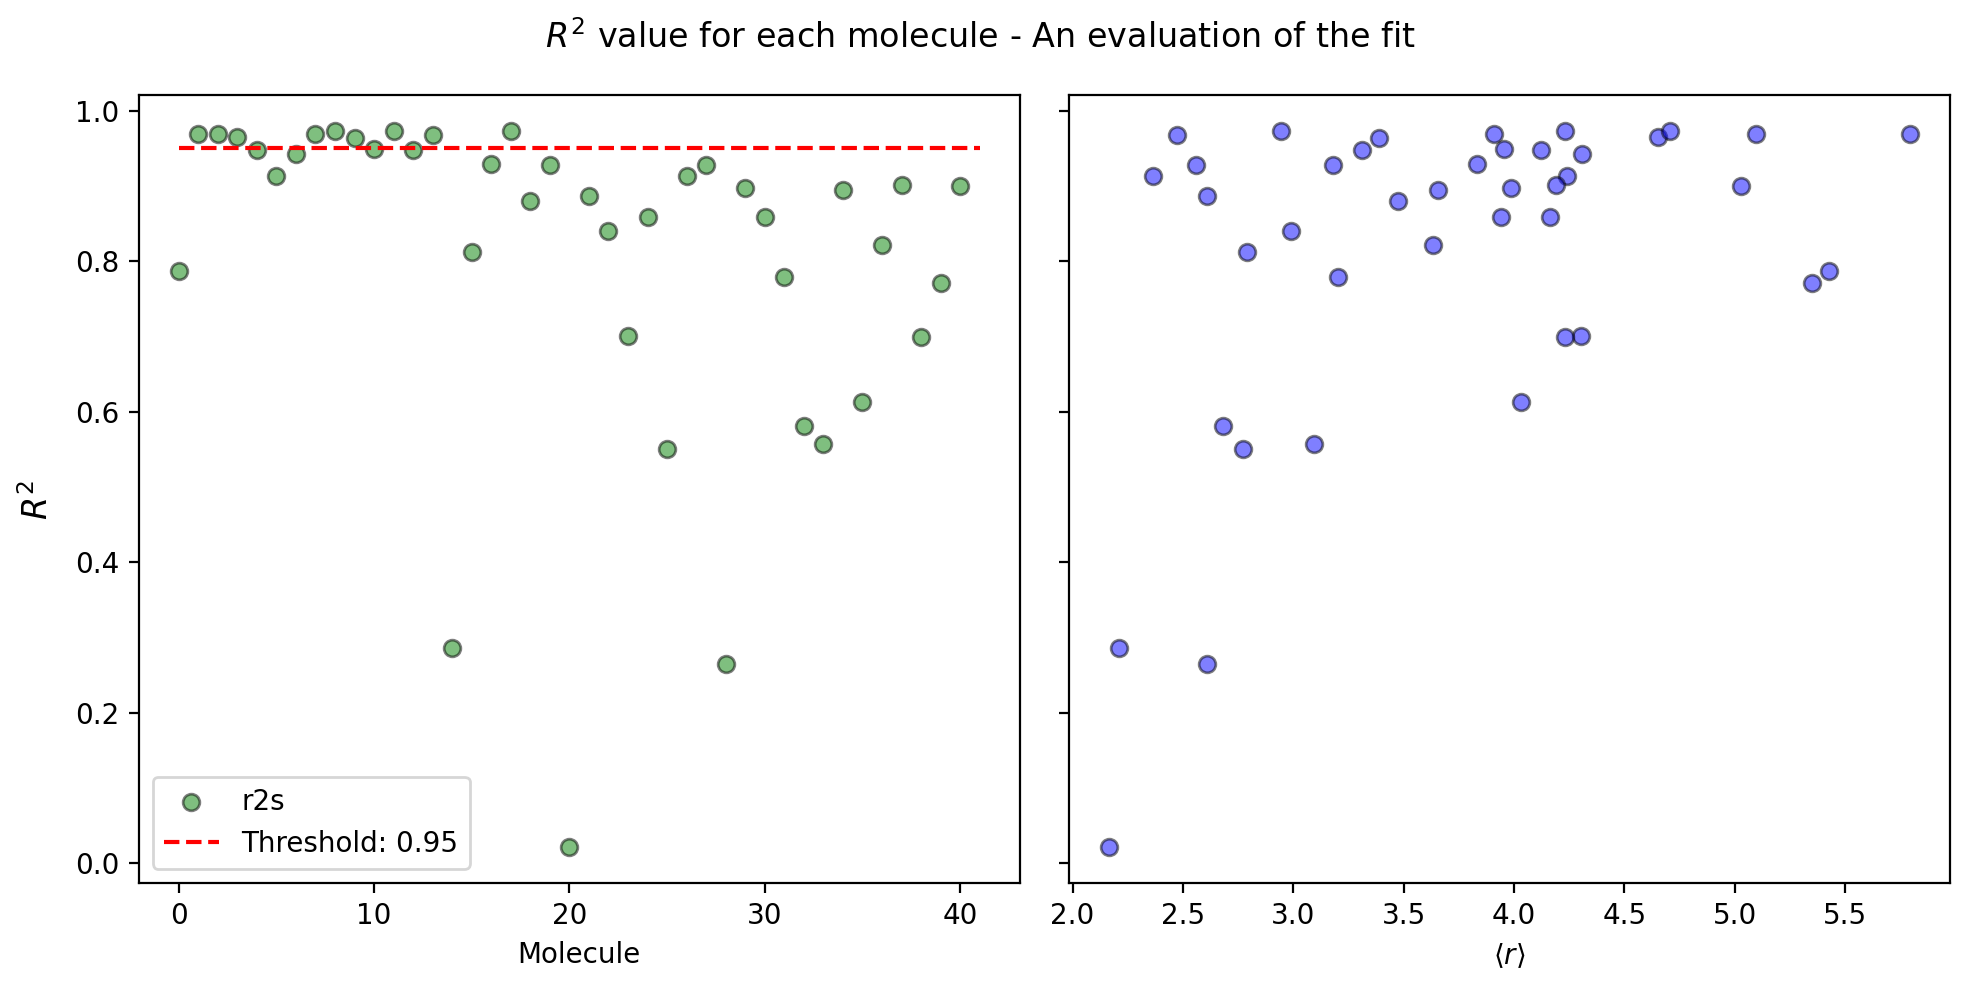

In [ ]:
# Visualization of the Rsquared
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=200, sharey=True)
axs[0].scatter(np.arange(0, tot_mol), r2s, color='g', edgecolor='k', alpha=0.5, label='r2s')
axs[0].hlines(filt_r2, 0, tot_mol, color='r', linestyle='dashed', label=f'Threshold: {filt_r2}')
axs[0].set_xlabel(r'Molecule')
axs[0].legend()

axs[1].scatter(mean_rad, r2s, color='b', edgecolor='k', alpha=0.5)
axs[1].set_xlabel(r'$\langle r \rangle$')

fig.supylabel(r'$R^2$')
fig.suptitle(r"$R^2$ value for each molecule - An evaluation of the fit")

plt.tight_layout()
plt.show()

#### Plotting $\tau(r)$

Lets see the result and the comparison evaluating the $R^2$ filtering.

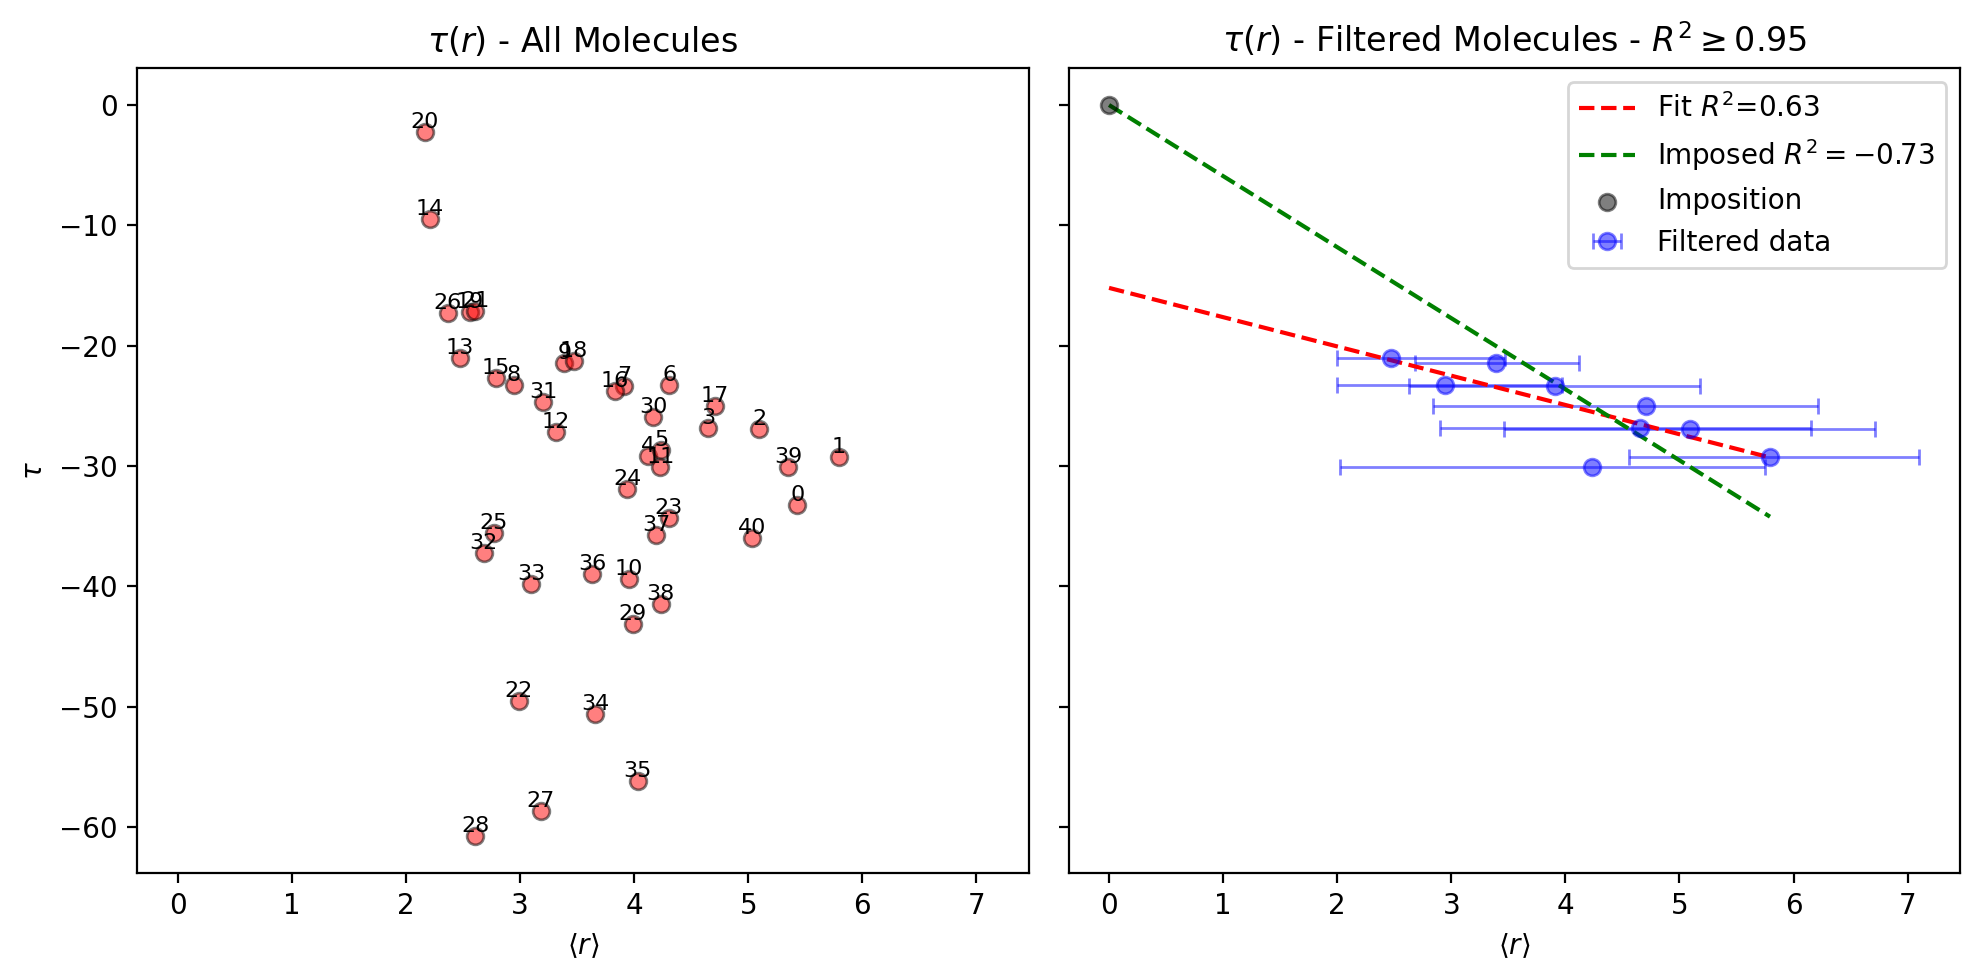

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=200, sharex=True, sharey=True)

# --- Left: original tau ---
axs[0].scatter(mean_rad, tau, color='r', edgecolor='k', alpha=0.5)

for i, (x, y) in enumerate(zip(mean_rad, tau)):
    axs[0].text(x, y, str(i), fontsize=8, ha='center', va='bottom')

axs[0].set_ylabel(r'$\tau$')
axs[0].set_title(r"$\tau(r)$ - All Molecules")

# --- Right: filtered tau ---
axs[1].errorbar(mean_rad_filt, tau_filt, xerr=std_rad_filt, fmt='o', color='b', mfc='b', mec='b', alpha=0.5, capsize=3, elinewidth=1, label='Filtered data')

# Fit and Evaluation
m, b, r2filt = linfitandr2(mean_rad_filt, tau_filt)
fit = np.poly1d((m, b))
r_plt = np.linspace(0, max(mean_rad_filt), 100)
axs[1].plot(r_plt, fit(r_plt), linestyle='dashed', color='r', label=rf"Fit $R^2$={r2filt:.2f}")
axs[1].set_title(rf"$\tau(r)$ - Filtered Molecules - $R^2 \geq${filt_r2}")
axs[1].legend()

fig.suptitle(r'Analysis of slopes, $\tau$')
fig.supxlabel(r'$\langle r \rangle$')
plt.tight_layout()
plt.show()

#### Plotting $\psi(r)$

The ACTUAL twist

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=200, sharex=True)

# --- Left: original psi ---
axs[0].scatter(mean_rad, psi, color='r', edgecolor='k', alpha=0.5)

for i, (x, y) in enumerate(zip(mean_rad, psi)):
    axs[0].text(x, y, str(i), fontsize=8, ha='center', va='bottom')

axs[0].set_ylabel(r'$\psi$ (deg)')
axs[0].set_title(r"$\psi(r)$ - All Molecules")

# --- Right: filtered psi ---
axs[1].errorbar(mean_rad_filt, psi_filt, xerr=err_rad_filt, fmt='o', color='b', mfc='b', mec='b', alpha=0.5, capsize=3, elinewidth=1, label='Filtered data')
axs[1].set_title(rf"$\psi(r)$ - Filtered Molecules - $R^2 \geq${filt_r2}")
axs[1].set_ylabel(r'$\psi(r)$ (deg)')
axs[1].legend()

fig.suptitle(r'Analysis of Twist (Angle with $z$ axis), $\psi$')
fig.supxlabel(r'$\langle r \rangle$')
plt.tight_layout()
plt.show()